# Market Segmentation Analysis using Machine Learning and Location data 


**Identifying the best location to open a new restaurant**  
*Calgary, Alberta, Canada*

*By:* Mahmood Khordoo, March 2019


## 1.Introduction
Manual site selection for business owners is still a very difficult problem. Finding the right location involves trying to quantify lots of variables that are hard to quantify and measure manually.
In this project, we will try to subvert these obstacles by combining powerful data from multiple sources such as population, business license renewal, FourSquare location API with different machine learning techniques to model the problem and try to answer these question.
The target city of the analysis is the City of Calgary located in Alberta, Canada. We believe that this approach can be used to make better decisions about where to open a new restaurant.

### 1.1 Bussiness Problem 
As mentioned before, the goal here is to help a new business owner to find the best location for its restaurant in the City of Calgary. There are several factors that could influence business success. Our focus in this study is to answer the following questions as they could potentially help a business to succeed :

  - Where should a new restaurant be located?
  - What type of restaurant would be best in a given location? 
  - How will competition down the block or across town impact market share? 

To summarize, We will use multiple data sources with different machine learning models (in particular K-mean clustering) to study the complex, dynamic, and often unobserved factors that would help to identify the best location for a new restaurant in the city.

### 1.2 City Info
Calgary, a cosmopolitan Alberta city with numerous skyscrapers, owes its rapid growth to its status as the center of Canada’s oil industry. However, it’s still steeped in the western culture that earned it the nickname “Cowtown,” evident in the Calgary Stampede. It has a population of 1.2 million people. (2016 census).


Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [123]:
import requests
import pandas as pd
import geopandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import os
from matplotlib.cm import gist_rainbow
from collections import defaultdict
from bs4 import BeautifulSoup
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans ,DBSCAN
from sklearn import metrics
pd.set_option('display.expand_frame_repr',True)
pd.set_option('display.max_columns',None)


*ٔNote:The codes are hidden for more readibilly.You can toggle the code display using the following botton:*

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## 2. Data Source

To build a powerful machine learning model, we needed powerful data. We will use the FourSquare API location data along with the different data sources from the web to identify the market segmentation in each part of the city.
Understanding of restaurant similarity and local food preferences are amongst the factors that we consider to be important in our site selection hypotheticals.

### 2.1 Main data sources
 - Neighbourhood boundaries in GeoJSON format([City of Calgary Open Data](https://data.calgary.ca/Base-Maps/Community-Boundaries/ab7m-fwn6)) 
 - Calgary Business Licenses Renewal ([source](https://data.calgary.ca))
 - Calgary Neighourboohd Crime data ([source](https://data.calgary.ca)) 
 - Calgary Census data-count of dwelling units and population ([source](https://data.calgary.ca)) 
 - Neighourboohd Groups based on the Postal Codes ([source](http://totallycalgary.ca/loc/) )
 - Foursquare Location API ([source](https://foursquare.com/))

We will use these data along with the explore function of the FourSquare API to get the most common venue categories in each neighborhood, and then we will use this feature to group the neighborhoods into clusters. We can then suggest the location for each business based on the locations with the most similar business. We are also considering the distance to industrial zones, population density, crimes rate and the number of renewed business licenses in our analysis.

We believe this approach can be used not only to make better decisions about where to put restaurants but could also help to identify where to put other types of businesses like general Oil and Gas or Technology offices as well. The details of the approach and analysis will be presented and discussed in the methodology section.

### 2.2 Libraries and APIs
We will use the location data from the [Foursquare](https://foursquare.com/) Location API to explore neighborhoods in Calgary.

We will also use these library convert addresses into their equivalent latitude and longitude values.

Here is a summary of location data libraries and APIs : 
- FourSquare  API
- Geopy
- Geopandas


## 2.2 Downloading the data
In order to explore the different neighborhood in Calgary we use two sources of the data: 

- Neighourhoods based on the PostalCode (Fiding Neighbourhood Names)
- Neighbourhoods based on the City classification boundaries (Finding boundaries)


This dataset for neoighbourhood names exists for free. We use the data provided in this http://totallycalgary.ca/loc/ to map the postal code to the neighbourhood name and then will map them to the neighbourhood boundaries.
### 2.2.1 Downloading the PostaCode page
We use the request library to download a page containing the postal codes and neighbourthoods of Calgary.

In [3]:
table_html=requests.get('http://totallycalgary.ca/loc/')
table_html=table_html.text

### 1.2 Parsing the HTML Table
Here we use the Beautiful Package to parse the content of the HTML options in the page and extract the required Postal code and their corresponding neighbourhood information.

In [4]:
soup=BeautifulSoup(table_html,'html.parser')
select=soup.findAll('select',{'name':"location", 'class':"location-search"})
options=BeautifulSoup(table_html,'html.parser').find_all('option')
neighbourhoods=defaultdict(list)
for row_index,option in enumerate(options):
    if row_index<=54:
        continue    
    if 'postal code' in option.text.lower():
        postal_code=option.text.strip().split()[0]
    else:
        neighbourhoods[postal_code].append(option.text.strip())
neighbourhoods
for postalcode ,neighbourhood in neighbourhoods.items():
    flatten=[','.join(neighbourhoods[postalcode])]
    neighbourhoods[postalcode]=flatten
    
neighbourhoods =pd.DataFrame.from_dict(neighbourhoods).transpose()
neighbourhoods.reset_index(inplace=True)
neighbourhoods.columns=['postalcode','neighbourhood']
neighbourhoods.sort_values(by='postalcode',inplace=True)
neighbourhoods.reset_index(inplace=True ,drop=True)
neighbourhoods.to_csv('postalcode_neighbourhoods.csv')
neighbourhoods

postalcode                                      neighbourhood
0         T1Y  Horizon,Monterey Park,Pineridge,Rundle,Sunridg...
1         T2A  Abbeydale,Albert Park/Radisson Heights,Applewo...
2         T2B  Dover,Erin Woods,South Foothills,Southview,Val...
3         T2C  Quarry Park,Riverbend,Shepard Industrial,Starf...
4         T2E  Bridgeland/Riverside,Calgary International Air...
5         T2G  Alyth/Bonnybrook,Downtown East Village,Golden ...
6         T2H  Burns Industrial,East Fairview Industrial,Fair...
7         T2J  Acadia,Bonavista Downs,Deer Ridge,Deer Run,Dia...
8         T2K  Cambrian Heights,Greenview,Highland Park,Highw...
9         T2L                  Brentwood,Charleswood,Collingwood
10        T2M  Banff Trail,Capitol Hill,Crescent Heights,Moun...
11        T2N  Hillhurst,Hounsfield Heights/Briar Hill,Parkda...
12        T2P  Chinatown,Downtown Commercial Core,Downtown We...
13        T2S  Britannia,Cliff Bungalow,Erlton,Mission,Parkhi...
14        T2T  Altadore,Bankview,Beltline,Elbow Park,Marda Lo...
15        T2V  Bayview,Bel-Aire,Chinook Park,Eagle Ridge,Elbo...
16        T2W  Braeside,Canyon Meadows,Cedarbrae,Southwood,Wo...
17        T2X  Chaparral,Legacy,Midnapore,Silverado,Sundance,...
18        T2Y  Bridlewood,Evergreen,Evergreen Estates,Millris...
19        T2Z  Copperfield,Douglasdale/Glen,Mckenzie Lake,Mck...
20        T3A  Dalhousie,Edgemont,Hamptons,Hidden Valley,Varsity
21        T3B  Bowness,Greenwood/Greenbriar,Montgomery,Point ...
22        T3C  Rosscarrock,Scarboro,Shaganappi,Spruce Cliff,S...
23        T3E  Currie Barracks,Glamorgan,Glenbrook,Glendale,K...
24        T3G  Arbour Lake,Citadel,Hawkwood,Ranchlands,Rocky ...
25        T3H  Aspen Woods,Christie Park,Coach Hill,Cougar Ri...
26        T3J  Castleridge,Coral Springs,Falconridge,Martinda...
27        T3K  Beddington Heights,Carrington,Country Hills,Co...
28        T3L                               Scenic Acres,Tuscany
29        T3M                          Auburn Bay,Cranston,Seton
30        T3N  Cityscape,Redstone,Saddle Ridge Industrial,Sky...
31        T3R  Evanston,Kincora,Livingston,Nolan Hill,Sage Hi...
32        T3S  East Shepard Industrial,Mahogany,Southwest Cal...

As you can see, the city of Calgary can be divided into 33 Neighbourhoods based o the postal codes.

### 2.2.1 Downloading the Neighbourhood boundaries.

The city of Calgary Open data provides the boundaries of the neighbourhoods along with some information about them in a GeoJSON file. We have already downloaded the file.

Let's load the data using the geopandas library and display a few rows.


In [5]:
communities=geopandas.read_file('datasets/Community Boundaries.geojson')
communities.head()

comm_structure                   name     sector class_code         srg  \
0     INNER CITY                SUNALTA     CENTRE          1   BUILT-OUT   
1   BUILDING OUT           WEST SPRINGS       WEST          1  DEVELOPING   
2          OTHER                    12A  SOUTHEAST          4         N/A   
3          1950s           WINDSOR PARK     CENTRE          1   BUILT-OUT   
4          OTHER  UNIVERSITY OF CALGARY  NORTHWEST          1   BUILT-OUT   

               class comm_code  \
0        Residential       SNA   
1        Residential       WSP   
2  Residual Sub Area       12A   
3        Residential       WND   
4        Residential       UOC   

                                            geometry  
0  POLYGON ((-114.10061493005 51.047994301993, -1...  
1  POLYGON ((-114.187805990867 51.061506344418, -...  
2  POLYGON ((-113.869446537594 50.979572332142, -...  
3  POLYGON ((-114.081517547811 51.008716296692, -...  
4  POLYGON ((-114.141027621875 51.074356354528, -...

Lets see how many zones we have in the City Calgary based on this data:
    

In [6]:
communities_type=pd.DataFrame(communities['class'].value_counts())
communities_type

class
Residential          212
Residual Sub Area     48
Industrial            42
Major Park             4

As we can see the city is divided into four major zones two Residential zones along with  Industrial and Major Parks. In general, we have 260 residential neighborhoods in Calgary.

Let's plot these zones to have a better understanding of their location.

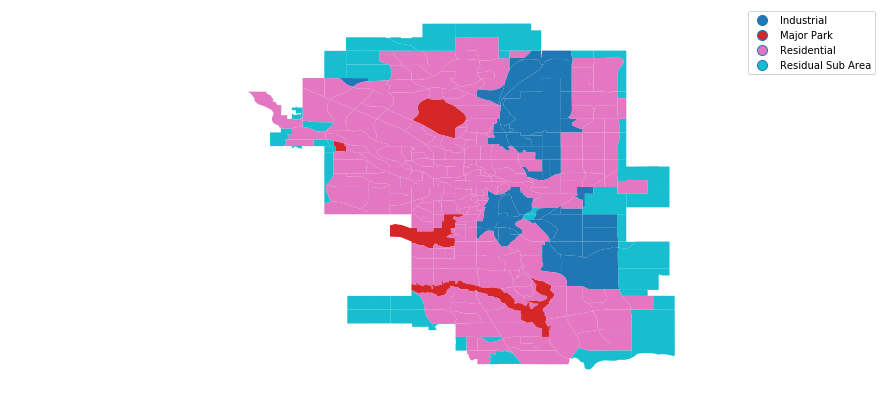

In [7]:
fig,ax=plt.subplots(figsize=(15,7))
communities.plot(column='class',ax=ax,  legend = True)
ax.set_axis_off()
plt.axis('equal');


**Neighbourdoods Boundaries**: 
Let's take a look at different neighbourhood boundaries

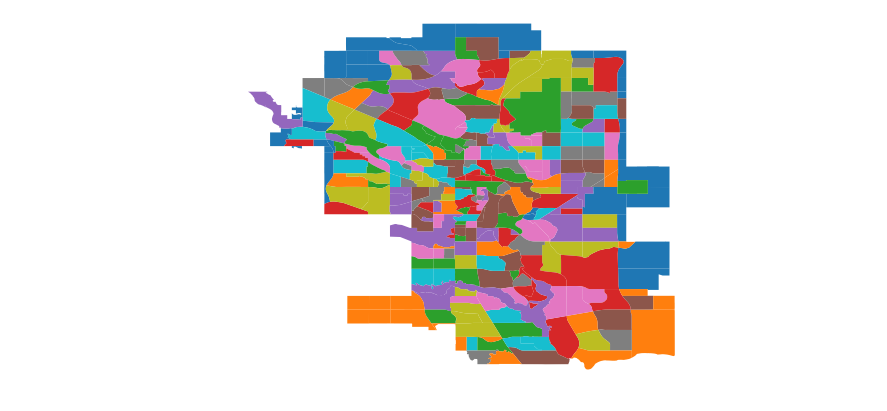

In [8]:
fig,ax=plt.subplots(figsize=(15,7))
communities.plot(column='name',ax=ax,  legend = False)
ax.set_axis_off()
plt.axis('equal');

### 2.2.2 Population density
In this section we load the Calgary Census data for each neighbourhood in 2016.Lets load and have a look at the data:

In [9]:
population=geopandas.read_file('datasets/Census By Community 2017.geojson')
population['res_cnt']=population['res_cnt'].astype(int)
population.head()

other_res comm_structure dup_occpd mfh_owned res_comm              name  \
0         0          OTHER         0         0        0               09H   
1         0     EMPLOYMENT         0         0        0       OGDEN SHOPS   
2         0     EMPLOYMENT         0         0        0           PEGASUS   
3         0    1960s/1970s       521       108        0  HUNTINGTON HILLS   
4         0     EMPLOYMENT         0         0        0           HORIZON   

  twn_no_res hotel_cnt mul_no_res apt_uc oth_strty town_house apt_no_res  \
0          0         0          0      0         0          0          0   
1          0         0          0      0         0          0          0   
2          0         1          0      0         1          0          0   
3          2         2          0      0         2       1195          0   
4          0         5          0      0         5          0          0   

  cnss_yr cnv_owned  res_cnt twn_occpd emplyd_cnt mul_owned twn_owned  \
0    2017         0        0         0          0         0         0   
1    2017         0        0         0          0         0         0   
2    2017         0        0         0          0         0         0   
3    2017        17    13154      1113          0         0       289   
4    2017         0       27         0          0         0         0   

  mul_occpd dup_na sf_person oth_owned fem_20_24 fem_5_14 male_25_34  \
0         0      0         0         0         0        0          0   
1         0      0         0         0         0        0          0   
2         0      0         0         0         0        0          0   
3         6      0      7591         0         0        0          0   
4         0      0         0         0         0        0          0   

  twn_vacant fem_75 mul_person twn_uc nursing_hm mfh_person dwell_cnt  \
0          0      0          0      0          0          0         0   
1          0      0          0      0          0          0         0   
2          0      0          0      0          0          0         1   
3         79      0         11      0          0        234      5610   
4          0      0          0      0          0          0         5   

  fem_45_54 twn_person mul_uc other_sch mfh_na cnv_uc mf_35_44 dup_owned  \
0         0          0      0         0      0      0        0         0   
1         0          0      0         0      0      0        0         0   
2         0          0      0         0      0      0        0         0   
3         0       2786      0       148      0      0        0       186   
4         0          0      0         0      0      0        0         0   

  dwelsz_6 elect_cnt mfh_occpd foip_ind oth_uc apartment sing_famly sf_na  \
0        0         0         0     None      0         0          0     0   
1        0         0         0     None      0         0          0     0   
2        0         0         0     None      0         0          0     0   
3      149      7056       122     None      0       527       2957     2   
4        2         0         0     None      0         0          0     0   

  apt_person mf_0_4 other_inst apt_owned cnv_vacant mf_5_14 comunl_hse  \
0          0      0          0         0          0       0          0   
1          0      0          0         0          0       0          0   
2          0      0          0         0          0       0          0   
3        839      0          0       113         64       0          0   
4          0      0          0         0          0       0          0   

  pubsep_sch fem_15_19     sector mul_vacant manuf_home male_65_74 dwelsz_4_5  \
0          0         0       EAST          0          0          0          0   
1          0         0       EAST          0          0          0          0   
2          0         0  NORTHEAST          0          0          0          0   
3        197         0      NORTH          1        126          0        923   
4

Lets take a look at the population density map :

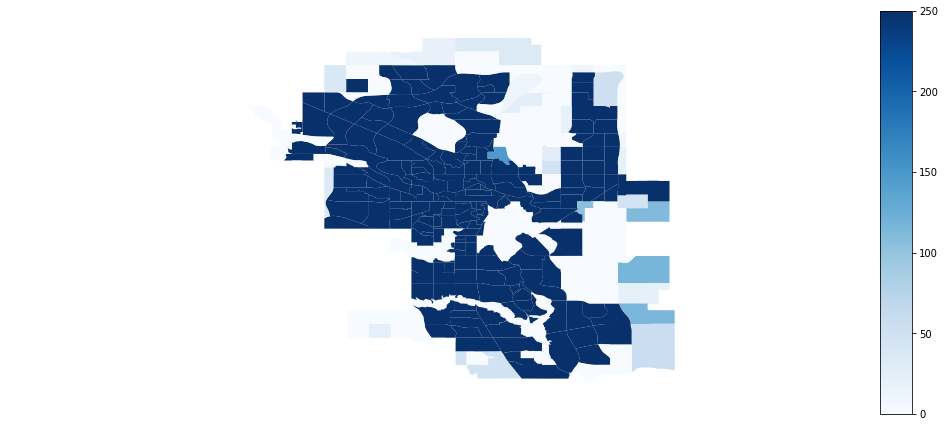

In [10]:
fig,ax=plt.subplots(figsize=(15,7))

vmin, vmax = population['res_cnt'].min(), 250
population.plot(column='res_cnt',ax=ax,  legend = False , cmap='Blues',vmin=vmin, vmax=vmax)
ax.set_axis_off()
plt.axis('equal');
# ax = gdf.plot(column='val', colormap='hot', vmin=vmin, vmax=vmax)

# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax)

As we can see the industrial areas have  very low population density as expected.The main populated areas of the City seems to be center ( Downtown ) and west side of the city.This could have an effect on the site selection of our business.

### 2.2.3 Commercial License Renewal
Here we are going to load the commercial renewal license data.This would show the main area of the city which has the highest number of businesses.
Lets load and take a look at the data.

In [11]:
licenses=geopandas.read_file('datasets/Calgary_Business_Licenses_Map.csv')
numeric_list=['latitude','longitude','Count']
for name in numeric_list:
    licenses[name]=licenses[name].astype(float)
licenses.head()

TRADENAME                       ADDRESS  \
0           MORE CONVENIENCE STORE                11201 30 ST SW   
1                  PIZZA HUT #4787  #3103 55 SKYVIEW RANCH RD NE   
2                         WASHTECH            #335 3750 46 AV SE   
3                            CUBEX             9304 HORTON RD SW   
4  DEREK BROWNS ACADEMY OF DRIVING                 1809 42 ST SE   

                           LICENCETYPES      COMDISTNM     JOBSTATUSDESC  \
0              RETAIL DEALER - PREMISES      CEDARBRAE  RENEWAL LICENSED   
1  FOOD SERVICE - PREMISES (NO SEATING)  SKYVIEW RANCH  RENEWAL LICENSED   
2              RETAIL DEALER - PREMISES      EASTFIELD  RENEWAL LICENSED   
3                            WHOLESALER       HAYSBORO  RENEWAL LICENSED   
4             SCHOOL (DRIVER EDUCATION)    FOREST LAWN          LICENSED   

               JOBCREATED   longitude   latitude  \
0  06/11/2009 12:00:00 AM -114.130062  50.953449   
1  11/23/2011 12:00:00 AM -113.962411  51.164824   
2  06/18/2007 12:00:00 AM -113.975667  51.013644   
3  01/07/2014 12:00:00 AM -114.075268  50.971295   
4  08/30/2018 12:00:00 AM -113.973418  51.037579   

                                location  Count geometry  
0  (50.9534492575157, -114.130062103058)    1.0     None  
1  (51.1648244314122, -113.962411153446)    1.0     None  
2  (51.0136444587222, -113.975667203559)    1.0     None  
3  (50.9712947174267, -114.075267980215)    1.0     None  
4  (51.0375794945847, -113.973418360852)    1.0     None

Lets see how many different type of businesses do we have in the data:

In [12]:
bussiness_type=pd.DataFrame(licenses['LICENCETYPES'].value_counts())[:20]
bussiness_type['LICENCETYPES_PCT']=bussiness_type['LICENCETYPES']*100/bussiness_type['LICENCETYPES'].sum()
bussiness_type.head(10)

LICENCETYPES  LICENCETYPES_PCT
RETAIL DEALER - PREMISES                              6491         23.899116
FOOD SERVICE - PREMISES (SEATING)                     2864         10.544919
FOOD SERVICE - PREMISES                               2120          7.805596
WHOLESALER                                            2032          7.481591
MANUFACTURER                                          1647          6.064065
PERSONAL SERVICE                                      1529          5.629602
CONTRACTOR                                            1463          5.386598
ALCOHOL BEVERAGE SALES (RESTAURANT)                   1207          4.444035
FOOD SERVICE - PREMISES (NO SEATING)                  1123          4.134757
APARTMENT BUILDING OPERATOR (1 TO 3 STOREYS)           927          3.413108

In [13]:
bussiness_type.reset_index(inplace=True)

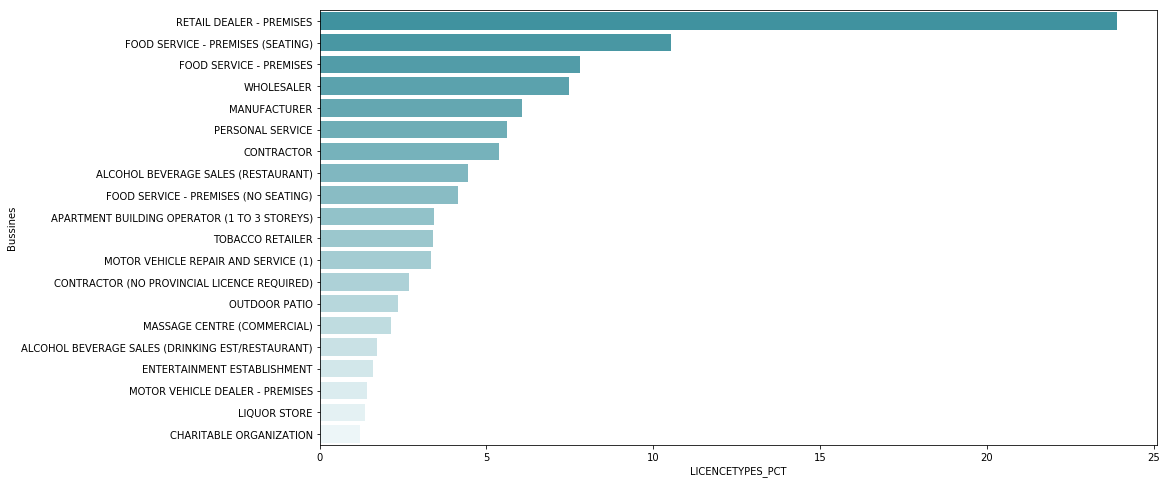

In [14]:
bussiness_type.rename(columns={'index':'Bussines'},inplace=True)
f,ax=plt.subplots(figsize=(15,8))
pallet=sns.light_palette((210, 90, 60),len(bussiness_type), input="husl",reverse=True)
sns.barplot(x='LICENCETYPES_PCT',y='Bussines',data=bussiness_type,ax=ax,palette=pallet)

As we can see restaurant business(FOOD SERVICE(SEATING)) is in fact the second most popular business in Calgary.We will use these information to find their clusters and This would greatly help us to identify the target location for our restaurant.

**Distribution of the Bussiness**

Lets use folium library to plot the distribution of different type of businesses on the City map

In [15]:
#Calculating the mean location fo each category
licenses_gr=licenses.groupby('LICENCETYPES').mean()
licenses_gr.sort_values(by='Count',inplace=True,ascending=False)
licenses_gr.reset_index(inplace=True)
licenses_gr['LICENCETYPES_CAT']=pd.Categorical(licenses_gr['LICENCETYPES']).codes
licenses_gr.head()

LICENCETYPES   longitude   latitude  \
0             ADVERTISER CANVASSER OR DISTRIBUTOR -114.044790  51.045828   
1  MOTOR VEHICLE REPAIR AND SERVICE (MOBILE WASH) -114.007455  51.041693   
2         PERSONAL SERVICE (FITNESS CONDITIONING) -114.061819  51.024043   
3                                PERSONAL SERVICE -114.072682  51.035016   
4                   PAYDAY LENDER (GRANDFATHERED) -114.048975  51.039014   

   Count  LICENCETYPES_CAT  
0    1.0                 0  
1    1.0                59  
2    1.0                68  
3    1.0                67  
4    1.0                66

In order to plot the data based on their categories we need to convert the license type to numerical values.We use Pandas Categorical utility

## Plotting Top 20 Business distributions

In [16]:
colors=np.array(sns.color_palette("gist_rainbow", licenses_gr.shape[0]))*255
# colors=np.array(sns.cubehelix_palette(total_bussiness_count, start=.5, rot=-.75))*255
# colors=np.array(sns.diverging_palette(10, 220, sep=80, n=licenses_gr.shape[0]))*255
colors
colorMap=defaultdict(str)
for index,color in enumerate(colors): 
        color=np.append(color,0.5)
        colorMap[index]='rgba'+str(tuple(color))

m=folium.Map(location=[51.0486,-114.0708],zoom_start=10,
             tiles='https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png', 
	         attr= '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
            )
for index, row in licenses_gr.iterrows():
    label = '{}, {}'.format( row['LICENCETYPES'], ' ')
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [row['latitude'], row['longitude']],
        radius=5,
        popup=label,
        color=colorMap[row['LICENCETYPES_CAT']],
        fill=True,
        fill_color=colorMap[row['LICENCETYPES_CAT']],
        fill_opacity=0.7,
        parse_html=False).add_to(m)

m

## Plotting Food Services
In the next plot we show the mean center for food businesses.This includes the following categories:
- Food Service Premises (Seating)
- Food Service Premises

In [17]:
licenses_food=licenses[licenses['LICENCETYPES'].isin(['FOOD SERVICE - PREMISES (SEATING)','FOOD SERVICE - PREMISES'])]


In [18]:
def get_color(food_service):
    if food_service=='FOOD SERVICE - PREMISES (SEATING)':
        return '#FF0000'
    else:
        return '#00FF00'

m=folium.Map(location=[51.0486,-114.0708],zoom_start=10,
             tiles='https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png', 
	         attr= '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
            )
for index, row in licenses_food[:1000].iterrows():
    label = '{}, {}'.format( row['LICENCETYPES'], ' ')
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [row['latitude'], row['longitude']],
        radius=3,
        popup=label,
        color=get_color(row['LICENCETYPES']),
        fill=True,
        fill_color=get_color(row['LICENCETYPES']),
        fill_opacity=0.7,
        parse_html=False).add_to(m)

m

In the above map the red dots shows the FOOD SERVICE - PREMISES (SEATING) and the green shown the Food Service Premises categories respectively.
As you can see we can not find a very good pattern in the data visually.Lets use the K-mean algorithm to find  the cluster center for each category:

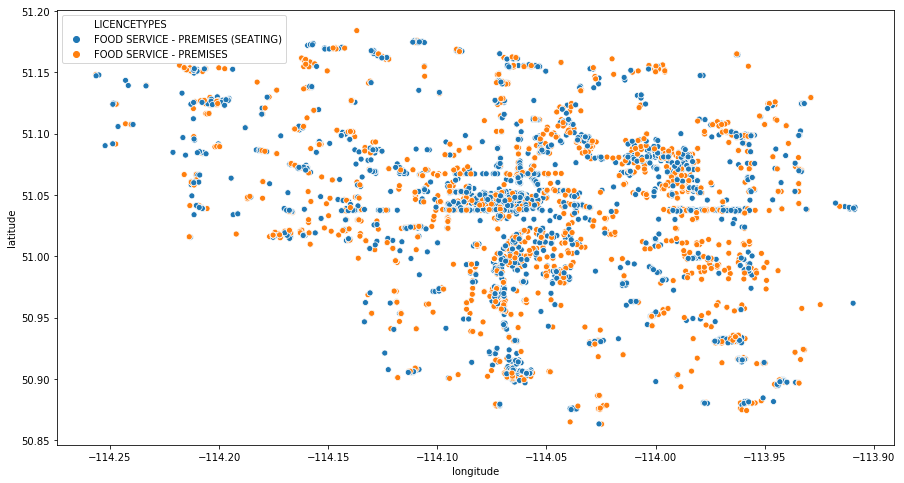

In [19]:
f,ax=plt.subplots(figsize=(15,8))
sns.scatterplot(x='longitude',y='latitude',data=licenses_food,hue=licenses_food['LICENCETYPES'],ax=ax)

As you can see the data are highly scattered across the city and it is highly unlikely that the K-Mean algorithm can separate these two classes from each other.

# 4. Cluster Centers for Food Businesses
### 4.1 K Mean clustering
In the above map the red dots shows the FOOD SERVICE - PREMISES (SEATING) and the green shown the Food Service Premises categories respectively. As you can see we can not find a very good pattern in the data visually.Lets use the K-mean algorithm to find the cluster center for each category:

In [20]:
licenses_food_clustering=licenses_food[['latitude','longitude']]
licenses_food_clustering.head()

latitude   longitude
11  50.879272 -113.959724
12  51.037467 -113.980436
14  51.023429 -114.107628
21  51.060466 -114.136802
25  51.066458 -114.063494

### 4.2 Optimum number of Clusters
We use the elbow method to find the optimum number of clusters in the data.
Here we plot the sum of squared distances to the closest centroid for all observations vs the number of clusters.The optimum number of cluster seems to be 5

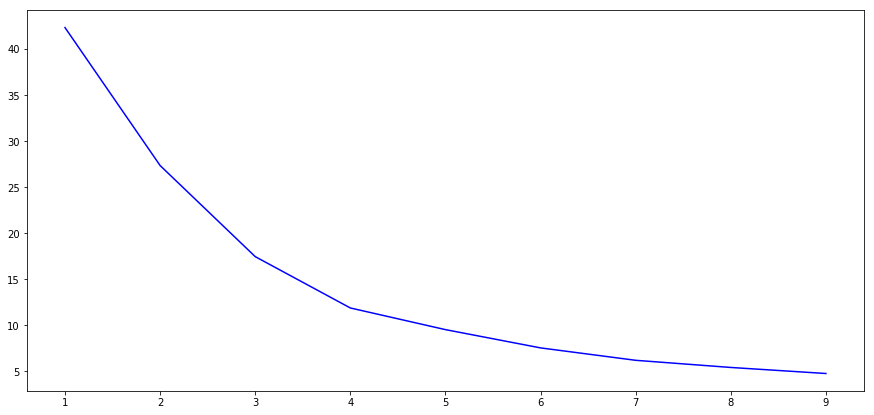

In [21]:
Kmax=10
square_errros=[]
k_values=[k for k in range(1 , Kmax)]
for k in range(1,Kmax):
    kmeans=KMeans(n_clusters=k,random_state=42).fit(licenses_food_clustering)
    square_errros.append(kmeans.inertia_)
f,ax=plt.subplots(figsize=(15,7))
sns.lineplot(x=k_values,y=square_errros,color='Blue' ,markers=True ,ax=ax)    

We can see that the optimum number of cluster is 6.
Folium can not handle drawing a large amount of data.So Lets plot the centers on along with all the point on a Scatter plot:

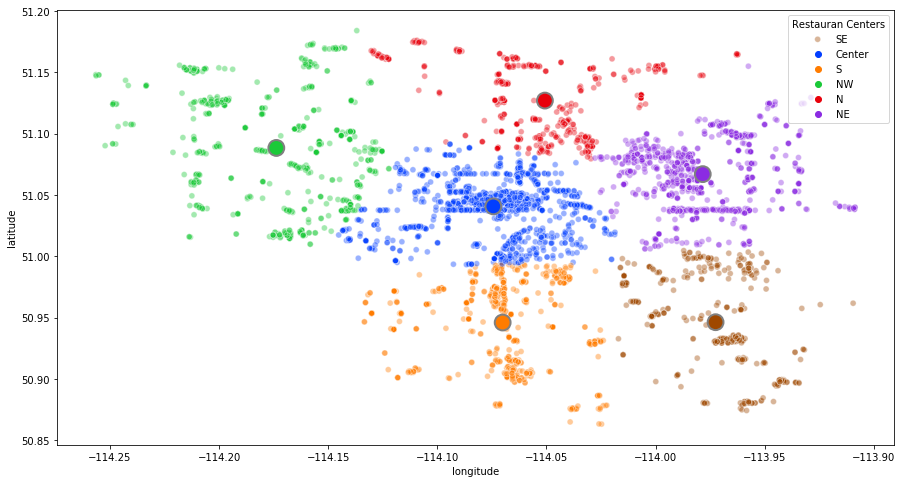

In [233]:
n_clusters=6
# run k-means clustering
kmeans=KMeans(n_clusters=n_clusters,random_state=42).fit(licenses_food_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_
centers=kmeans.cluster_centers_
center_latitudes=[center[0] for center in centers]
cetner_longitudes=[center[1] for center in centers]
f,ax=plt.subplots(figsize=(15,8))
palette = sns.color_palette("bright", n_clusters)

sns.scatterplot(x='longitude',y='latitude',data=licenses_food,hue=kmeans.labels_,ax=ax , palette=palette,alpha=0.4 )
sns.scatterplot(x=cetner_longitudes,y=center_latitudes,hue=[i for i in range(n_clusters)], palette=palette,s=250 ,ax=ax , edgecolor='gray',linewidth=2 ,legend=False )
new_labels = ["SE","Center","S" ,'NW','N','NE']
plt.legend(title='Restauran Centers', loc='upper right', labels=new_labels)

### 4.3 Market Share per Region
Lets find the number of restaurants in each region to see which area is more popular:


In [237]:
def location_to_area_mapper(latitude,longitude):
    if longitude<-114.1:
        return 'NW'
    elif  longitude> -114:
         if latitude> 51:  
            return 'NE'
         else:
            return 'SE'    
    else:
        if latitude> 51.1:
            return 'North'
        elif latitude< 51:
            return 'S'
        else:
            return 'Center' 
                
cluster_memebers=pd.DataFrame(kmeans.labels_,columns=['cluster'])
cluster_memebers_gr=licenses_food_clustering.copy()
cluster_memebers_gr['cluster']=kmeans.predict(cluster_memebers_gr)
cluster_to_area_map={}
for index,center in enumerate(kmeans.cluster_centers_):
      cluster_to_area_map[index]=location_to_area_mapper(center[0],center[1])

cluster_memebers_gr['area']=cluster_memebers_gr['cluster'].copy()
for index,row in cluster_memebers_gr.iterrows():
    cluster_memebers_gr.loc[index,'area']=cluster_to_area_map[row['cluster']]
    

cluster_grouped=cluster_memebers_gr.groupby(['area']).count()
cluster_grouped.reset_index(inplace=True)
cluster_grouped.rename(columns={'cluster':'restaurant_count' ,'area':'region'},inplace=True)
cluster_grouped['restaurant_share']=cluster_grouped['restaurant_count']*100/cluster_grouped['restaurant_count'].sum()
cluster_grouped.sort_values(by='restaurant_share',ascending=False,inplace=True)
cluster_grouped[['region','restaurant_share']]

region  restaurant_share
0  Center         34.931782
1      NE         19.542536
2      NW         14.727127
4       S         13.402889
3   North          9.610754
5      SE          7.784912

Lets plot the restaurant share of each area of the city :

Text(0.5, 1.0, 'Resutrant share if different regions of the City(%)')

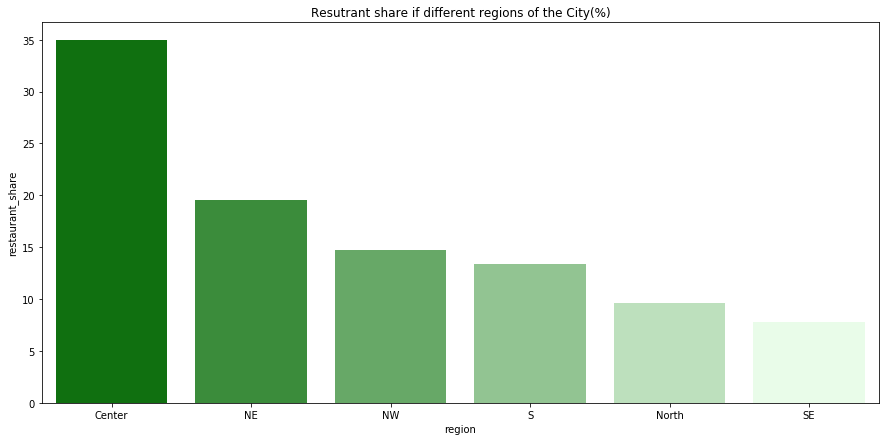

In [238]:
fig ,ax=plt.subplots(figsize=(15,7))
sns.barplot(x='region',y='restaurant_share',data=cluster_grouped,ax=ax ,palette=sns.light_palette("green", reverse=True))
ax.set_title('Resutrant share if different regions of the City(%)')

In [25]:
m=folium.Map(location=[51.0486,-114.0708],zoom_start=10,
             tiles='https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png', 
	         attr= '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
            )

for index,coordinates in enumerate(kmeans.cluster_centers_):
    folium.CircleMarker(
        [coordinates[0], coordinates[1]],
        radius=7,
        popup=location_to_area_mapper(coordinates[0], coordinates[1])+' : '+ json.dumps([coordinates[0], coordinates[1]]),
        color='orange',
        fill=True,
        fill_color='orange',
        fill_opacity=1,
        parse_html=False).add_to(m)

m

### 4.2 Recommended location
The following coordinate shows the coordinates of the best location for opening a restaurant in Calgary : 


In [26]:
best_locations=pd.DataFrame(kmeans.cluster_centers_,columns=['latitude','longitude'])
best_locations['area']=best_locations['latitude'].copy()
for index, row in best_locations.iterrows():
     best_locations.loc[index,'area']=location_to_area_mapper(row['latitude'],row['longitude']) 
best_locations


latitude   longitude    area
0  50.954995 -114.070993       S
1  51.051511 -114.073327  Centre
2  51.079709 -113.987043      NE
3  51.094039 -114.169078      NW
4  50.948672 -113.974758      SE

Best Locations: 
    - City Center: 
    - NW
    - NE
    - S
    - SE

Let's create a new dataframe that includes the cluster as well as the business name.

### 2.2.3 Using four square API
In order to use the Foursquare API first we calculate the central location for each neighbourhood.



In [36]:
communities['latitude']=communities.centroid.map(lambda p : p.y)
communities['longitude']=communities.centroid.map(lambda p : p.x)


Lets plot the central location of each community:

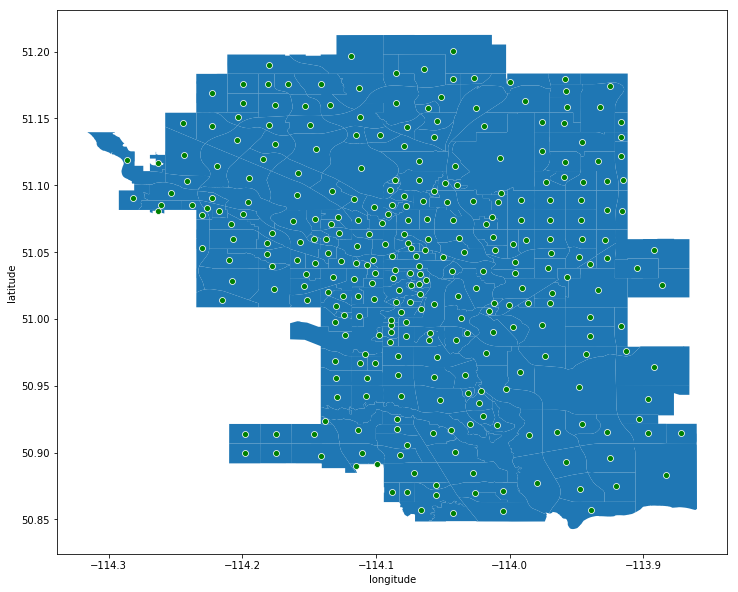

In [35]:
fig,ax =plt.subplots(figsize=(20,10))
communities.plot(ax=ax)
sns.scatterplot(x='longitude',y='latitude',data=communities,ax=ax,color='green')

### Calculating Neighbourhood Radius
The next step is to find the radius of each neghoubordood.We Do this by first calculating the area of each neghoubordood and then use some arithemtic calculation to find teh radius of a circle that would fit whitin this area.
#### 1.1 Convert to Cartesian system
We change the the projection to a Cartesian system (EPSG:3857, unit= m as in the answer of ResMar) so that the radius would be in meter unit.

In [39]:
communities_cart=communities.to_crs({'init': 'epsg:3857'})
communities_cart.head()

comm_structure                   name     sector class_code         srg  \
0     INNER CITY                SUNALTA     CENTRE          1   BUILT-OUT   
1   BUILDING OUT           WEST SPRINGS       WEST          1  DEVELOPING   
2          OTHER                    12A  SOUTHEAST          4         N/A   
3          1950s           WINDSOR PARK     CENTRE          1   BUILT-OUT   
4          OTHER  UNIVERSITY OF CALGARY  NORTHWEST          1   BUILT-OUT   

               class comm_code  \
0        Residential       SNA   
1        Residential       WSP   
2  Residual Sub Area       12A   
3        Residential       WND   
4        Residential       UOC   

                                            geometry   latitude   longitude  \
0  POLYGON ((-12701622.35321255 6629787.754034879...  51.044111 -114.102245   
1  POLYGON ((-12711328.41770443 6632180.702772607...  51.059737 -114.206740   
2  POLYGON ((-12675888.80547685 6617681.099955483...  50.964226 -113.891704   
3  POLYGON ((-12699496.44234622 6622835.679554586...  51.004862 -114.081594   
4  POLYGON ((-12706121.0734881 6634457.055266358,...  51.076088 -114.128346   

       area  
0  0.000121  
1  0.000522  
2  0.001489  
3  0.000163  
4  0.000193

#### 2. Calculate the radius for each neighbourhood:
As we can see from the above table the uni of geometry are now in meteres and therefroe we can go ahead and calculate the area of each district and then find the fitting circle in each neighbourhood

In [42]:
communities_cart['radius']=np.sqrt(communities_cart.area/np.pi)
communities_cart.head()

comm_structure                   name     sector class_code         srg  \
0     INNER CITY                SUNALTA     CENTRE          1   BUILT-OUT   
1   BUILDING OUT           WEST SPRINGS       WEST          1  DEVELOPING   
2          OTHER                    12A  SOUTHEAST          4         N/A   
3          1950s           WINDSOR PARK     CENTRE          1   BUILT-OUT   
4          OTHER  UNIVERSITY OF CALGARY  NORTHWEST          1   BUILT-OUT   

               class comm_code  \
0        Residential       SNA   
1        Residential       WSP   
2  Residual Sub Area       12A   
3        Residential       WND   
4        Residential       UOC   

                                            geometry   latitude   longitude  \
0  POLYGON ((-12701622.35321255 6629787.754034879...  51.044111 -114.102245   
1  POLYGON ((-12711328.41770443 6632180.702772607...  51.059737 -114.206740   
2  POLYGON ((-12675888.80547685 6617681.099955483...  50.964226 -113.891704   
3  POLYGON ((-12699496.44234622 6622835.679554586...  51.004862 -114.081594   
4  POLYGON ((-12706121.0734881 6634457.055266358,...  51.076088 -114.128346   

           area       radius  
0  2.377215e+06   869.879981  
1  1.030098e+07  1810.774584  
2  2.930043e+07  3053.950745  
3  3.219299e+06  1012.291871  
4  3.798638e+06  1099.610884

Text(0.5, 1.0, 'Average Neighbourhood Radius')

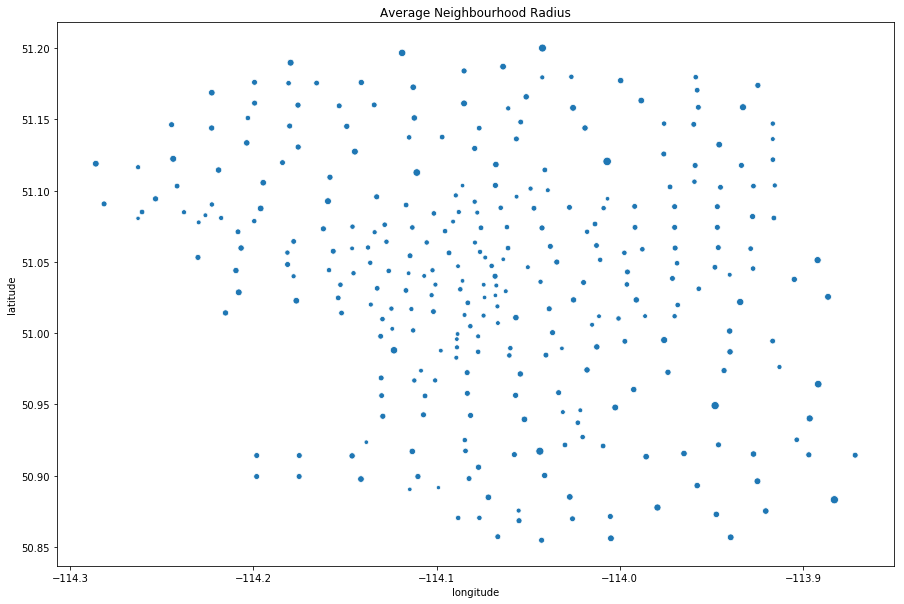

In [53]:
f,ax =plt.subplots(figsize=(15,10))
sns.scatterplot(x='longitude',y='latitude',data=communities_cart ,size='radius' ,ax=ax ,legend=False)
ax.set_title('Average Neighbourhood Radius')

### Define Foursquare Credentials and Version

In [37]:
CLIENT_ID = 'DDKJFMDJVCQDOMJ5VQ2JN3X3LO3W2AQBG0ZZAVVYLOYCDDCF' # your Foursquare ID
CLIENT_SECRET = 'SQVPM0MWXJP5XVJO3UF45MZAZ3BPRO4LB5PJ21LNCKT4CAC3' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DDKJFMDJVCQDOMJ5VQ2JN3X3LO3W2AQBG0ZZAVVYLOYCDDCF
CLIENT_SECRET:SQVPM0MWXJP5XVJO3UF45MZAZ3BPRO4LB5PJ21LNCKT4CAC3


## 1. Search for a specific venue category:
#### Now, let's  let's define a query to search for restaurants which are that is within the average radius of each neighbourhood. 
To avoid fetching the data multiple time from the API ,we save the result into a data frame and load it in subsequent runs

In [117]:
def get_value(value):
    if not isinstance(value,str):
        return value
    value=value.strip()
    if len(value.strip())>0:
        return value
    return 'N/A'
def extract_restuarant_info(venues):
    dframe=defaultdict(list) 
    for index, venue in enumerate(venues):
        latitude=get_value(venue['location']['lat'])
        longitude=get_value(venue['location']['lng'])
        name=get_value(venue['name'])
        cat_name='N/A'
        cat_pluralName='N/A'
        cat_shortName='N/A'
        if len(venue['categories'])>0:
            cat_name=venue['categories'][0]['name']
            cat_pluralName=venue['categories'][0]['pluralName']
            cat_shortName=venue['categories'][0]['shortName']      
        
        dframe['latitude'].append(latitude)
        dframe['longitude'].append(longitude)
        dframe['name'].append(name)
        dframe['cat_name'].append(cat_name)
        dframe['cat_pluralName'].append(cat_pluralName)
        dframe['cat_shortName'].append(cat_shortName)         
    return pd.DataFrame(dframe)   

In [137]:
search_query = 'restaurant'
restaurants=pd.DataFrame()
LIMIT=1000
if os.path.isfile('restaurants_foursquare.csv'):
    restaurants=pd.read_csv('restaurants_foursquare.csv')
    print('Reloaded the data from file!')
else:
    for index, row in communities_cart.iterrows():
        latitude, longitude,radius =row['latitude'],row['longitude'],row['radius']
        neighbourhood=row['name']
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)    
        results = requests.get(url).json() 
        venues = results['response']['venues']
        parsed=extract_restuarant_info(venues)
        restaurants=restaurants.append(parsed)
        restaurants.to_csv('restaurants_foursquare.csv')
    print('All done!')

Reloaded the data from file!


Lets take a look at the data:

In [127]:
restaurants.head()

Unnamed: 0   latitude   longitude                           name  \
0           0  51.044450 -114.092754      Korean Village Restaurant   
1           1  51.037457 -114.094972          Moti Mahal Restaurant   
2           2  51.037839 -114.095126  Green Chili Indian Restaurant   
3           3  51.043242 -114.092588      Christos Greek Restaurant   
4           4  51.038006 -114.095573   The Rock Cafe and Restaurant   

                     cat_name               cat_pluralName    cat_shortName  
0           Korean Restaurant           Korean Restaurants           Korean  
1           Indian Restaurant           Indian Restaurants           Indian  
2           Indian Restaurant           Indian Restaurants           Indian  
3            Greek Restaurant            Greek Restaurants            Greek  
4  Modern European Restaurant  Modern European Restaurants  Modern European

### Fiding missing values
Lets see if we have any missing values for the short Catgory names.This is important siince later on we want to Classify restautant based on this short name:

In [143]:
restaurants.isnull().sum()

Unnamed: 0          0
latitude            0
longitude           0
name                0
cat_name          108
cat_pluralName    108
cat_shortName     108
dtype: int64

There are 108 restaurant which only have their name and their short name is missing.Lets take a look at one of these restaurants.

In [145]:
missing_name=restaurants[restaurants['cat_shortName'].isnull()]
missing_name.head()

Unnamed: 0   latitude   longitude                               name  \
5            5  51.038208 -114.094518  Oshii Village Japanese restaurant   
18           3  50.999720 -114.070960    Whiskey Restaurant - Saddledome   
23           3  51.085968 -114.128802                  Murder Restaurant   
35           7  51.081580 -113.985390          Misai Japanese restaurant   
36           8  51.081752 -114.000855        Basil Vietnamese Restaurant   

   cat_name cat_pluralName cat_shortName  
5       NaN            NaN           NaN  
18      NaN            NaN           NaN  
23      NaN            NaN           NaN  
35      NaN            NaN           NaN  
36      NaN            NaN           NaN

## Filling missing values
As we can see for some of these resturant ,we can identify its category from its name. For example Oshii Village Japanese restaurant doset have the short name but we can see that it is a Japanese restaurant.
To do these first we create a list of all the unique short Category names in the data.Then we will see if any of these words are present in the name of the restaurant and then we assign the class to its short name.
First lets create a list of all the unique short name for the category of restaurants:


In [148]:
unique_categories=restaurants['cat_shortName'].dropna().unique()
unique_categories

array(['Korean', 'Greek', 'Modern European', 'Szechuan', 'Indian',
       'Italian', 'Pub', 'Vietnamese', 'Breakfast', 'Restaurant',
       'Fast Food', 'Vegetarian / Vegan', 'Beer Garden', 'Japanese',
       'Chinese', 'Diner', 'Seafood', 'American', 'Sushi', 'Bar',
       'Filipino', 'South American', 'Thai', 'Hookah Bar', 'Gastropub',
       'Ethiopian', 'Eastern European', 'Lounge', 'Nightclub', 'Pizza',
       'Café', 'Steakhouse', 'Cocktail', 'Dim Sum', 'Shop', 'Falafel',
       'Mediterranean', 'Noodles', 'Brewery', 'Asian', 'Pakistani',
       'Entertainment', 'Office', 'Deli / Bodega', 'Mexican', 'Park',
       'Wine Bar', 'New American', 'Persian', 'Hotel Bar', 'Caribbean',
       'Peruvian', 'Latin American', 'French', 'Ice Cream', 'Hunan',
       'Wings'], dtype=object)

There are 57 unique categories for the restaurants.Now lets use these list to fill the missing values.

In [160]:
#Convert all unique categories to lower case
unique_categories_lower=[category.lower() for category in unique_categories]

#Checking if word in resturant name exists in categories
def category_finder(restaurant_full_name):
    words=restaurant_full_name.strip().lower().split()
    for word in words:
        if word in unique_categories_lower:
            return word.capitalize()
    return None    

Lets check our function to see if it identify the restaurants correctly:

In [161]:
category_finder('Oshii Village Japanese restaurant')


'Japanese'

Now,Lets apply these function to identify the missing restaurants classes in the whole dataset:a

In [165]:
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1335 entries, 0 to 1334
Data columns (total 7 columns):
Unnamed: 0        1335 non-null int64
latitude          1335 non-null float64
longitude         1335 non-null float64
name              1335 non-null object
cat_name          1227 non-null object
cat_pluralName    1227 non-null object
cat_shortName     1227 non-null object
dtypes: float64(2), int64(1), object(4)
memory usage: 73.1+ KB


In [178]:
for index, row in restaurants.iterrows():
    if pd.isnull(row['cat_shortName']):
        category=category_finder(row['name'])
        restaurants.loc[index,'cat_shortName']=category


In [179]:
restaurants.isnull().sum()

Unnamed: 0          0
latitude            0
longitude           0
name                0
cat_name          108
cat_pluralName    108
cat_shortName       3
dtype: int64

Great! We we able to correctly identify the category of 105 restaurant out of a total of 108 which is great.Lets see what are 3 missing restaurants that we were not able to identify

In [180]:
restaurants[restaurants['cat_shortName'].isnull()]

Unnamed: 0   latitude   longitude                              name  \
712           12  51.037909 -114.072639  El Sombrero Restaurante Mexicano   
1005          26  51.037909 -114.072639  El Sombrero Restaurante Mexicano   
1060          11  51.037909 -114.072639  El Sombrero Restaurante Mexicano   

     cat_name cat_pluralName cat_shortName  
712       NaN            NaN          None  
1005      NaN            NaN          None  
1060      NaN            NaN          None

We can see that these are the Mexican restaurants which belong to our South American category .So lets assign this category to these restaurants an by that we will not have any missing categories.


In [181]:
for index, row in restaurants.iterrows():
    if pd.isnull(row['cat_shortName']):
        restaurants.loc[index,'cat_shortName']='South American'

In [182]:
restaurants.isnull().sum()

Unnamed: 0          0
latitude            0
longitude           0
name                0
cat_name          108
cat_pluralName    108
cat_shortName       0
dtype: int64

Know we ca see that we do not have any missing values for the cat_shortName of the resturants and therefore we can proceed to the analysis section.

#### Let's plot the data to see their distributino on the map 

In [202]:
colors=sns.color_palette('Blues',len(unique_categories))
color_map={category:'rgb'+str(tuple(int(c*255) for c in colors[index])) for index,category in enumerate(unique_categories) }

m=folium.Map(location=[51.0486,-114.0708],zoom_start=10,
             tiles='https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png', 
	         attr= '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
            )

for index,row in restaurants.iterrows():
    label = folium.Popup(row['cat_shortName'], parse_html=True)
    folium.CircleMarker(
        [row['latitude'], row['longitude']],
        radius=3,
        popup=label,
        color=color_map[row['cat_shortName']],
        fill=True,
        fill_color=color_map[row['cat_shortName']],
        fill_opacity=0.7,
        parse_html=False).add_to(m)

m



## Clustering of the Restaurants

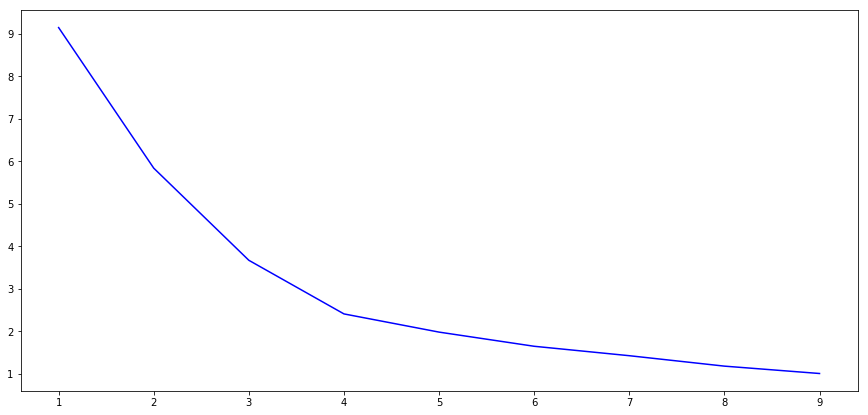

In [203]:
Kmax=10
square_errros=[]
k_values=[k for k in range(1 , Kmax)]
for k in range(1,Kmax):
    kmeans=KMeans(n_clusters=k,random_state=42).fit(restaurants[['latitude','longitude']])
    square_errros.append(kmeans.inertia_)
f,ax=plt.subplots(figsize=(15,7))
sns.lineplot(x=k_values,y=square_errros,color='Blue' ,markers=True ,ax=ax) 

From the above chart we can see that the optimum number of clusters is 6. This makes sense as it divides the city into six regions.

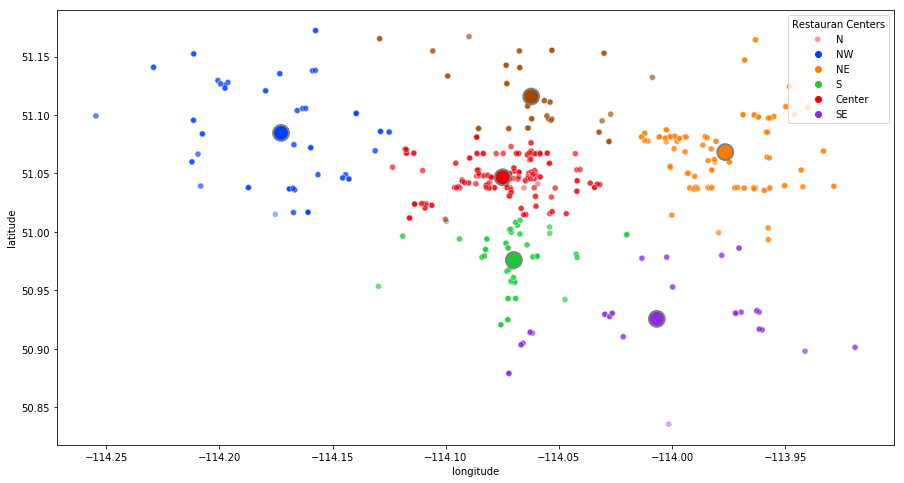

In [227]:
n_clusters=6
# run k-means clustering
kmeans=KMeans(n_clusters=n_clusters,random_state=42).fit(restaurants[['latitude','longitude']])
# check cluster labels generated for each row in the dataframe
kmeans.labels_
centers=kmeans.cluster_centers_
center_latitudes=[center[0] for center in centers]
cetner_longitudes=[center[1] for center in centers]
f,ax=plt.subplots(figsize=(15,8))
palette = sns.color_palette("bright", n_clusters)

sns.scatterplot(x='longitude',y='latitude',data=restaurants[['latitude','longitude']],hue=kmeans.labels_,ax=ax , palette=palette,alpha=0.4 )
sns.scatterplot(x=cetner_longitudes,y=center_latitudes,hue=[i for i in range(n_clusters)], palette=palette,s=250 ,ax=ax , edgecolor='gray',linewidth=2 ,legend=False )
new_labels = ["N","NW","NE" ,'S','Center','SE']
plt.legend(title='Restauran Centers', loc='upper right', labels=new_labels)

As we saw before with the license data ,again we see a similar pattern in the data and we can classify the data into five cluster.

## Top locations
Lest group the data based on the cluster and find out which region has the highest concentration of the restaurants:

In [243]:
def location_to_area_mapper(latitude,longitude):
    if longitude<-114.1:
        return 'NW'
    elif  longitude> -114.05:
         if latitude> 51:  
            return 'NE'
         else:
            return 'SE'    
    else:
        if latitude> 51.1:
            return 'North'
        elif latitude< 51:
            return 'S'
        else:
            return 'Center' 
# cluster_to_area_map={}                

cluster_memebers=pd.DataFrame(kmeans.labels_,columns=['cluster'])
cluster_memebers_gr=restaurants.copy()
cluster_memebers_gr['cluster']=kmeans.predict(restaurants[['latitude','longitude']])
cluster_to_area_map={}
for index,center in enumerate(kmeans.cluster_centers_):
      cluster_to_area_map[index]=location_to_area_mapper(center[0],center[1])

cluster_memebers_gr['area']=cluster_memebers_gr['cluster'].copy()
for index,row in cluster_memebers_gr.iterrows():
    cluster_memebers_gr.loc[index,'area']=cluster_to_area_map[row['cluster']]

cluster_grouped=cluster_memebers_gr.groupby(['area']).count()
cluster_grouped.reset_index(inplace=True)
cluster_grouped.rename(columns={'cluster':'restaurant_count' ,'area':'region'},inplace=True)
cluster_grouped['restaurant_share']=cluster_grouped['restaurant_count']*100/cluster_grouped['restaurant_count'].sum()
cluster_grouped.sort_values(by='restaurant_share',ascending=False,inplace=True)
cluster_grouped[['region','restaurant_share']]
# sns.scatterplot(x='longitude',y='latitude',data=cluster_memebers_gr,hue=cluster_memebers_gr['cluster'],palette=palette)
# cluster_to_area_map 

region  restaurant_share
0  Center         42.172285
1      NE         22.921348
4       S         11.910112
2      NW         10.786517
3   North          7.640449
5      SE          4.569288

Text(0.5, 1.0, 'Resutrant share if different regions of the City(%)')

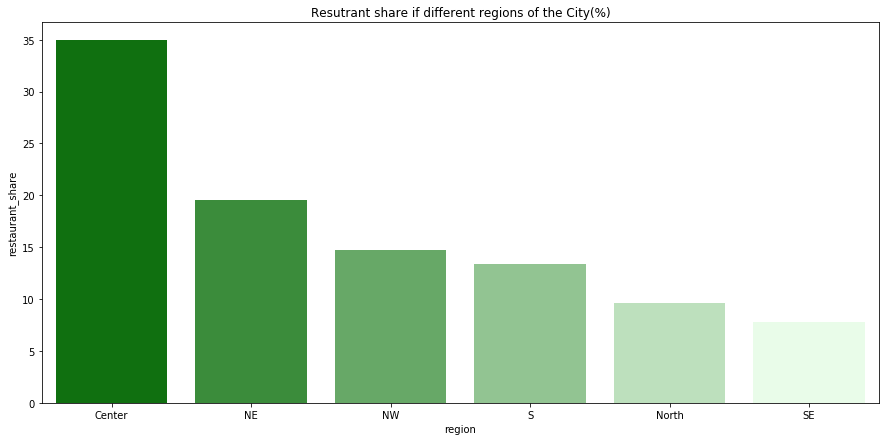

In [239]:
fig ,ax=plt.subplots(figsize=(15,7))
sns.barplot(x='region',y='restaurant_share',data=cluster_grouped,ax=ax ,palette=sns.light_palette("green", reverse=True))
ax.set_title('Resutrant share if different regions of the City(%)')

The results are in agreement with the previous analysis we obtain from the business license renewal data.As we can see the Center and NE areas are the top locations for opening a restaurants and SE is the least favorable place to open a restaurant business.This makes sense since the SE is an industrial area of the city.

## Top restaurant types
Lets first take a look at the top 10 popular restaurants type the city along with their location.
We can see the most popular type in Calgary is Chinese restaurant which are located in City center.This makes sense since the china town is also located in City center.
The second most popular one is Indian which are located in NE and the third is Vietnamese which are located in Center and NE.

In [256]:
resturant_gropued=cluster_memebers_gr.groupby(['area','cat_shortName'],as_index=False).count()

resturant_gropued.sort_values(by=['name'],ascending=False,inplace=True)
resturant_gropued['area-type']=resturant_gropued['cat_shortName']+' : '+resturant_gropued['area']
resturant_gropued.head(10)

area cat_shortName  Unnamed: 0  latitude  longitude  name  cat_name  \
7    Center       Chinese         102       102        102   102       102   
37   Center    Restaurant          90        90         90    90        56   
60       NE        Indian          41        41         41    41        41   
45   Center    Vietnamese          41        41         41    41        35   
70       NE    Vietnamese          37        37         37    37        32   
74       NW       Chinese          32        32         32    32        32   
26   Center        Korean          32        32         32    32        27   
65       NE    Restaurant          30        30         30    30        18   
115       S    Restaurant          29        29         29    29        21   
24   Center       Italian          29        29         29    29        29   

     cat_pluralName  cluster            area-type  
7               102      102     Chinese : Center  
37               56       90  Restaurant : Center  
60               41       41          Indian : NE  
45               35       41  Vietnamese : Center  
70               32       37      Vietnamese : NE  
74               32       32         Chinese : NW  
26               27       32      Korean : Center  
65               18       30      Restaurant : NE  
115              21       29       Restaurant : S  
24               29       29     Italian : Center

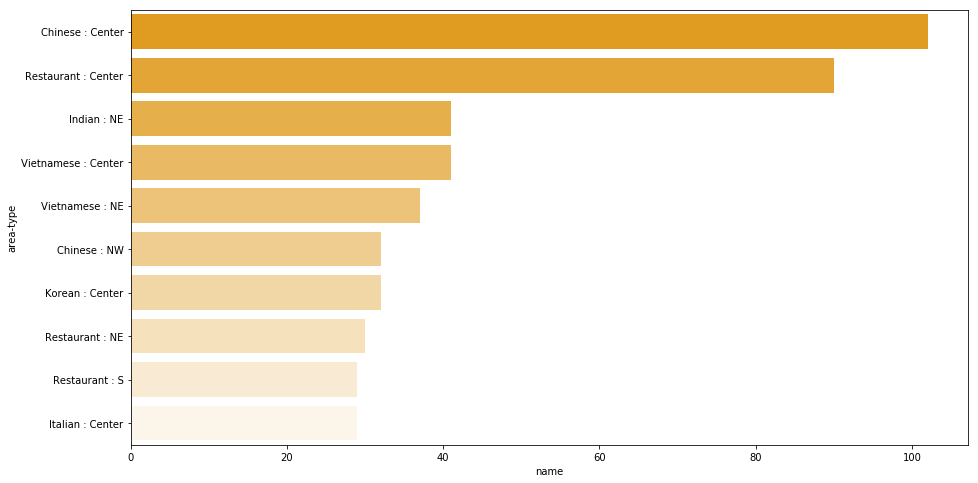

In [266]:
f,ax=plt.subplots(figsize=(15,8))
sns.barplot(x='name',y='area-type',data=resturant_gropued.head(10),palette=sns.light_palette("orange",10, reverse=True),ax=ax)

## Restaurant popularity per region
In this part lets find out what are the most popular restaurant types in each area of the city

In [278]:
TOP_LIMIT=5
poularity_by_area=defaultdict(list)
resturant_popularity=resturant_gropued.sort_values(by=['area','name'],ascending=False)
for index,row in resturant_popularity.iterrows():
    if len(poularity_by_area[row['area']])<=TOP_LIMIT:
          poularity_by_area[row['area']].append({"type":row['cat_shortName'],'count':row['name']})
       


Lest see the most popular restaurant type in each area of the city:


In [285]:
for area,restaurants in poularity_by_area.items():
    print(area)
    print(restaurants)
    print('=========================================\n')

SE
[{'type': 'Restaurant', 'count': 12}, {'type': 'Fast Food', 'count': 9}, {'type': 'Chinese', 'count': 8}, {'type': 'Brewery', 'count': 8}, {'type': 'Breakfast', 'count': 7}, {'type': 'Vietnamese', 'count': 5}]

S
[{'type': 'Restaurant', 'count': 29}, {'type': 'Chinese', 'count': 20}, {'type': 'Fast Food', 'count': 19}, {'type': 'Vietnamese', 'count': 10}, {'type': 'Breakfast', 'count': 10}, {'type': 'Filipino', 'count': 9}]

North
[{'type': 'Chinese', 'count': 26}, {'type': 'Fast Food', 'count': 15}, {'type': 'Restaurant', 'count': 11}, {'type': 'Vietnamese', 'count': 11}, {'type': 'Japanese', 'count': 11}, {'type': 'Diner', 'count': 5}]

NW
[{'type': 'Chinese', 'count': 32}, {'type': 'Fast Food', 'count': 28}, {'type': 'Restaurant', 'count': 17}, {'type': 'Vietnamese', 'count': 9}, {'type': 'Seafood', 'count': 8}, {'type': 'Japanese', 'count': 8}]

NE
[{'type': 'Indian', 'count': 41}, {'type': 'Vietnamese', 'count': 37}, {'type': 'Restaurant', 'count': 30}, {'type': 'Fast Food', 'c

## Conclusions
There are 6 major areas in the City of Calgary that has the high number of restauranst.We performed the restaurant site selection analysis using two different data sources : 
 - Business License Renewal 
 - Four Square API
 
 We came with the consistent conclusions with both datasets showing the central part of the city has the highest number of concentration of the restaurants.
These area is the most likely place to open a new shop.
We also identified the popularity of each type of restaurants in different areas of the city .So we can select the restaurant location based on the type of the restaurant as well.